In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers==4.45.2 datasets==2.19.1 scikit-learn torch evaluate pandas

import os, json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)
import torch

# === paths ===
JSON_DIR = Path("/content/drive/MyDrive/Jason_Training_Seed_Papers ")
SAVE_DIR = Path("/content/drive/MyDrive/TESTING_OUTPUT")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

MORAL_VALUES = [
    "Interpretable (to users)","Transparent (to users)","Privacy","Fairness",
    "Not socially biased","User influence","Collective influence","Deferral to humans",
    "Critiqability","Beneficence","Non-maleficence","Justice","Respect for Persons",
    "Autonomy (power to decide)","Explicability","Respect for Law and public interest"
]
IDX = {v:i for i,v in enumerate(MORAL_VALUES)}

# If your JSON saved only Yes/No (not scores), set TH=None. If you saved scores separately, you can use TH=0.6.
TH = None  # or e.g. 0.6 if you stored numeric scores

examples = []
for fp in sorted(JSON_DIR.glob("*.json")):
    try:
        d = json.loads(open(fp, encoding="utf-8").read())
    except Exception as e:
        print("[skip bad json]", fp, e); continue

    text = str(d.get("text","")).strip()
    if not text:
        continue

    values = d.get("values", {}) or {}
    y = np.zeros(len(MORAL_VALUES), dtype=np.float32)

    for k,v in values.items():
        if k not in IDX:
            continue
        if TH is None:
            # treat Yes/No strings
            y[IDX[k]] = 1.0 if str(v).strip().lower()=="yes" else 0.0
        else:
            # if you had numeric scores, use threshold
            y[IDX[k]] = 1.0 if float(v) >= TH else 0.0

    examples.append({"text": text, "labels": y.tolist()})

print("Total JSON examples:", len(examples))
pos_counts = np.sum(np.array([e["labels"] for e in examples]), axis=0)
print("Positives per label:", dict(zip(MORAL_VALUES, pos_counts.astype(int))))



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 633.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 78.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.3.1 which is incompatible.
Total JSON examples: 99
Positives per label: {'Interpretable (to users)': np.int64(26), 'Transparent (to users)': np.int64(21), 'Privacy': np.int64(22), 'Fairness': np.int64(20), 'Not socially biased': np.int64(21), 'User influence': np.int64(20), 'Collect

In [3]:
has_any = [int(sum(e["labels"])>0) for e in examples]
train_data, val_data = train_test_split(
    examples, test_size=0.2, random_state=42,
    stratify=has_any if len(set(has_any))>1 else None
)

train_ds = Dataset.from_list(train_data)
val_ds   = Dataset.from_list(val_data)

MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

def tok(b): return tokenizer(b["text"], truncation=True, max_length=512)
train_ds = train_ds.map(tok, batched=True, remove_columns=["text"])
val_ds   = val_ds.map(tok,   batched=True, remove_columns=["text"])

def to_float32(b):
    b["labels"] = [np.array(x, dtype=np.float32) for x in b["labels"]]
    return b
train_ds = train_ds.map(to_float32, batched=True)
val_ds   = val_ds.map(to_float32,   batched=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [4]:
num_labels = len(MORAL_VALUES)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=num_labels, problem_type="multi_label_classification"
)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# pos_weight = (N - pos)/pos per label
N = len(train_data)
pos = np.maximum(1.0, np.sum([e["labels"] for e in train_data], axis=0))
pos_weight = (N - pos) / pos
pos_weight_t = torch.tensor(pos_weight, dtype=torch.float)

from torch.nn import BCEWithLogitsLoss
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        out = model(**inputs)
        loss = BCEWithLogitsLoss(pos_weight=pos_weight_t.to(out.logits.device))(out.logits, labels)
        return (loss, out) if return_outputs else loss

def compute_metrics(p):
    logits, labels = p
    probs = 1/(1+np.exp(-logits))
    preds = (probs >= 0.5).astype(int)
    return {
        "micro_f1": f1_score(labels, preds, average="micro", zero_division=0),
        "macro_f1": f1_score(labels, preds, average="macro", zero_division=0),
        "micro_precision": precision_score(labels, preds, average="micro", zero_division=0),
        "micro_recall": recall_score(labels, preds, average="micro", zero_division=0),
    }

args = TrainingArguments(
    output_dir=str(SAVE_DIR/"logs"),
    num_train_epochs=20,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="micro_f1",
    greater_is_better=True,
    report_to=[]
)

trainer = WeightedTrainer(
    model=model, args=args,
    train_dataset=train_ds, eval_dataset=val_ds,
    data_collator=collator, tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
val_metrics = trainer.evaluate()
print(val_metrics)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Micro Precision,Micro Recall
1,No log,1.319738,0.284264,0.149679,0.261682,0.311111
2,No log,1.339920,0.062500,0.034091,0.500000,0.033333
3,1.101700,1.355030,0.000000,0.000000,0.000000,0.000000
4,1.101700,1.257159,0.183333,0.121843,0.366667,0.122222
5,1.035700,1.576345,0.392857,0.363907,0.423077,0.366667
6,1.035700,1.799341,0.342466,0.337058,0.446429,0.277778
7,1.035700,1.230983,0.551724,0.549130,0.495575,0.622222
8,0.986100,1.628962,0.458824,0.456119,0.487500,0.433333
9,0.986100,1.758507,0.458824,0.456119,0.487500,0.433333
10,0.639400,1.984551,0.415584,0.418056,0.500000,0.355556


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument i

{'eval_loss': 1.2309828996658325, 'eval_micro_f1': 0.5517241379310345, 'eval_macro_f1': 0.5491300366300367, 'eval_micro_precision': 0.49557522123893805, 'eval_micro_recall': 0.6222222222222222, 'eval_runtime': 44.1704, 'eval_samples_per_second': 0.453, 'eval_steps_per_second': 0.113, 'epoch': 20.0}


Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Full dataset size: 99


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Examples used for evaluation: 99

=== Global Binary Confusion (All Papers) ===
TN=55  FP=6  FN=21  TP=17  | Total=99
{'accuracy': np.float64(0.7272727272727273), 'precision': 0.7391304347826086, 'recall': 0.4473684210526316, 'f1': 0.5573770491803278}


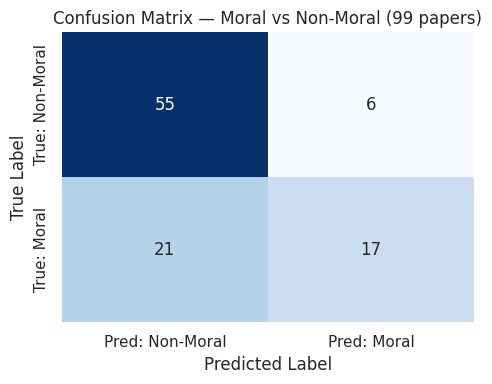


Saved per-value confusion table → /content/drive/MyDrive/TESTING_OUTPUT/per_value_confusion_full.csv


,Moral Value,Support_Positive,Precision,Recall,F1
0,Interpretable (to users),26,0.739130,0.653846,0.693878
1,Transparent (to users),21,0.727273,0.761905,0.744186
2,Privacy,22,0.727273,0.727273,0.727273
3,Fairness,20,0.681818,0.750000,0.714286
4,Not socially biased,21,0.681818,0.714286,0.697674
5,User influence,20,0.681818,0.750000,0.714286
6,Collective influence,20,0.681818,0.750000,0.714286
7,Deferral to humans,22,0.681818,0.681818,0.681818
8,Critiqability,19,0.681818,0.789474,0.731707
9,Beneficence,27,0.681818,0.555556,0.612245


In [5]:
import numpy as np
import pandas as pd
from datasets import Dataset
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# ================================
# 1) Build FULL DATASET (train + val)
# ================================
full_data = train_data + val_data  # list of dicts

full_ds = Dataset.from_list(full_data)
full_ds = full_ds.map(tok, batched=True, remove_columns=["text"])
full_ds = full_ds.map(to_float32, batched=True)

print("Full dataset size:", len(full_ds))

# ================================
# 2) Prediction on FULL set
# ================================
pred_full = trainer.predict(full_ds)
logits_f  = pred_full.predictions
labels_f  = pred_full.label_ids
probs_f   = 1 / (1 + np.exp(-logits_f))
preds_f   = (probs_f >= 0.5).astype(int)

N = labels_f.shape[0]
print("Examples used for evaluation:", N)

# ================================
# 3) BINARY: Moral vs Non-Moral
# ================================
true_bin_f = (labels_f.sum(axis=1) > 0).astype(int)
pred_bin_f = (preds_f.sum(axis=1) > 0).astype(int)

cm_bin = confusion_matrix(true_bin_f, pred_bin_f, labels=[0,1])
tn, fp, fn, tp = cm_bin.ravel()

acc  = (tp + tn) / (tp + tn + fp + fn)
prec = precision_score(true_bin_f, pred_bin_f, zero_division=0)
rec  = recall_score(true_bin_f, pred_bin_f, zero_division=0)
f1   = f1_score(true_bin_f, pred_bin_f, zero_division=0)

print("\n=== Global Binary Confusion (All Papers) ===")
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}  | Total={N}")
print({"accuracy":acc, "precision":prec, "recall":rec, "f1":f1})

# PLOT with human-readable labels
plt.figure(figsize=(5,4))
sns.heatmap(cm_bin, annot=True, fmt="d", cbar=False, cmap="Blues",
            xticklabels=["Pred: Non-Moral", "Pred: Moral"],
            yticklabels=["True: Non-Moral", "True: Moral"])
plt.title(f"Confusion Matrix — Moral vs Non-Moral ({N} papers)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# SAVE CSV
pd.DataFrame(cm_bin,
             index=["True: Non-Moral","True: Moral"],
             columns=["Pred: Non-Moral","Pred: Moral"]
            ).to_csv(SAVE_DIR / "cm_binary_full.csv")


# ================================
# 4) PER-VALUE CONFUSION MATRICES
# ================================
per_value_rows = []

for j, name in enumerate(MORAL_VALUES):
    y_true = labels_f[:, j]
    y_pred = preds_f[:, j]

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    p  = precision_score(y_true, y_pred, zero_division=0)
    r  = recall_score(y_true, y_pred, zero_division=0)
    f  = f1_score(y_true, y_pred, zero_division=0)

    per_value_rows.append({
        "Moral Value": name,
        "TN": int(tn), "FP": int(fp),
        "FN": int(fn), "TP": int(tp),
        "Support_Positive": int(y_true.sum()),
        "Support_Total": int(len(y_true)),
        "Precision": p, "Recall": r, "F1": f
    })

per_value_df = pd.DataFrame(per_value_rows)
per_value_df.to_csv(SAVE_DIR / "per_value_confusion_full.csv", index=False)

print("\nSaved per-value confusion table →", SAVE_DIR / "per_value_confusion_full.csv")
display(per_value_df[["Moral Value","Support_Positive","Precision","Recall","F1"]])


In [6]:
from pathlib import Path
import torch

# Use SAME folder for saving all files
SAVE_DIR = Path("/content/drive/MyDrive/TESTING_OUTPUT")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Save HuggingFace model (REQUIRED for testing)
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

# Optional: save .pth state_dict
torch.save(model.state_dict(), SAVE_DIR / "model_20e.pth")

print("✅ Saved model + tokenizer to:", SAVE_DIR)


✅ Saved model + tokenizer to: /content/drive/MyDrive/TESTING_OUTPUT


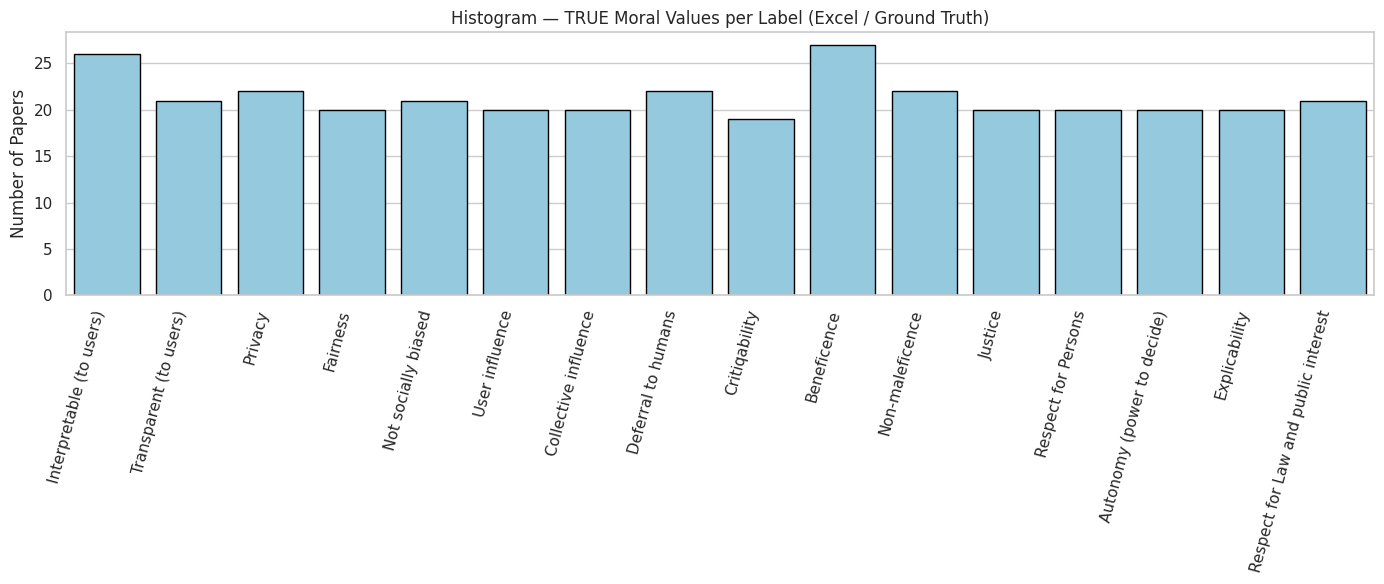

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# Count how many papers have each value predicted as Yes
value_counts = preds_f.sum(axis=0)    # preds_f is your predicted matrix [N,16]
true_counts  = labels_f.sum(axis=0)   # labels_f is ground truth

# Convert to arrays
value_names = MORAL_VALUES

plt.figure(figsize=(14,6))
sns.barplot(x=value_names, y=true_counts, color="skyblue", edgecolor="black")

plt.xticks(rotation=75, ha="right")
plt.ylabel("Number of Papers")
plt.title("Histogram — TRUE Moral Values per Label (Excel / Ground Truth)")
plt.tight_layout()
plt.show()

# Save CSV for histogram
pd.DataFrame({"label": value_names, "count": true_counts}).to_csv(
    SAVE_DIR/"histogram_true_value_counts.csv", index=False
)


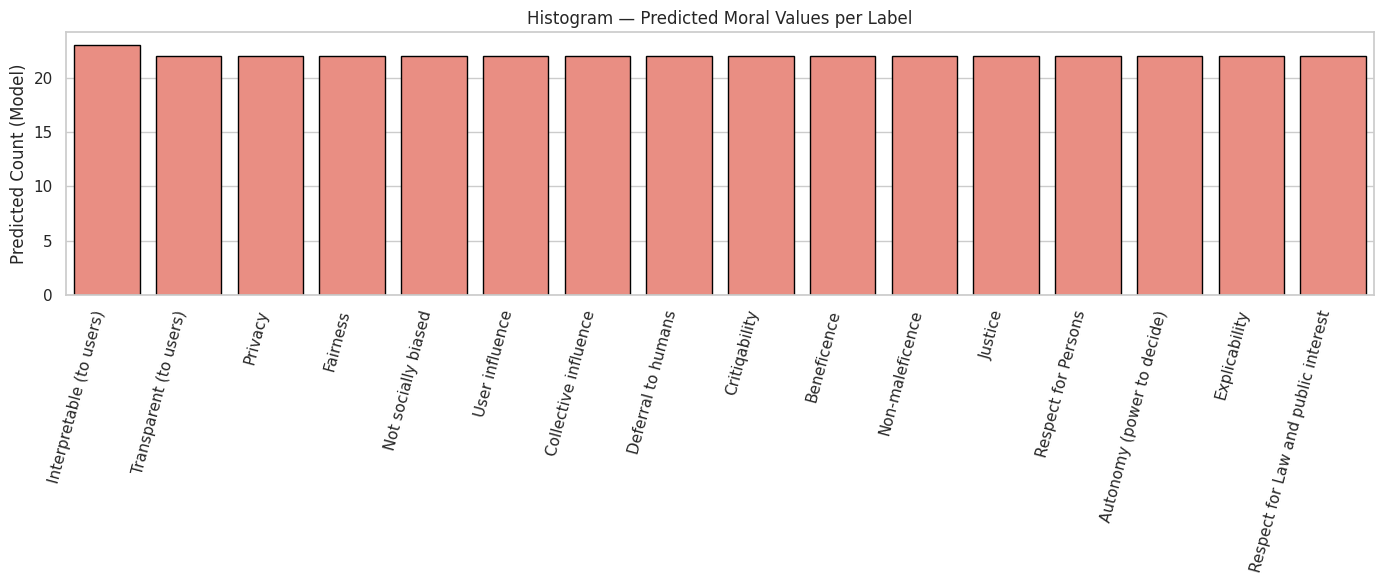

In [8]:
plt.figure(figsize=(14,6))
sns.barplot(x=value_names, y=value_counts, color="salmon", edgecolor="black")

plt.xticks(rotation=75, ha="right")
plt.ylabel("Predicted Count (Model)")
plt.title("Histogram — Predicted Moral Values per Label")
plt.tight_layout()
plt.show()

# Save CSV
pd.DataFrame({"label": value_names, "predicted_count": value_counts}).to_csv(
    SAVE_DIR/"histogram_predicted_value_counts.csv", index=False
)


/tmp/ipython-input-944098224.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=MORAL_VALUES, y=pred_yes_counts, palette="viridis")


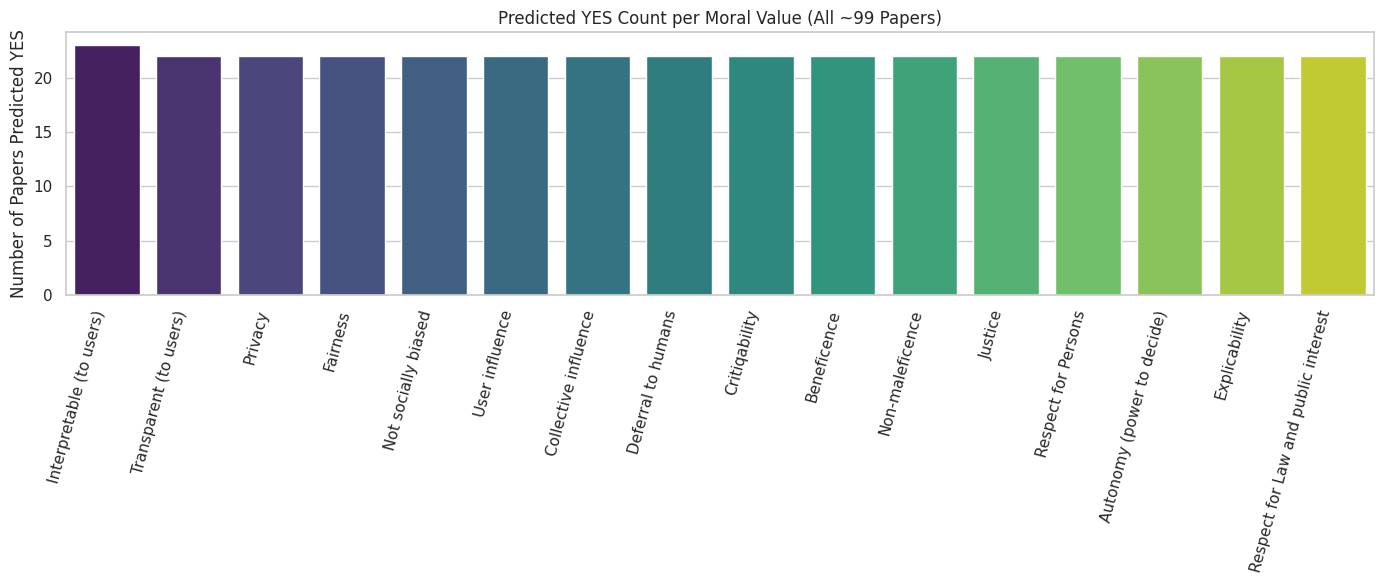

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Count predicted yes per label across full dataset
pred_yes_counts = preds_f.sum(axis=0)   # preds_f shape: [N,16]

plt.figure(figsize=(14,6))
sns.barplot(x=MORAL_VALUES, y=pred_yes_counts, palette="viridis")
plt.xticks(rotation=75, ha="right")
plt.ylabel("Number of Papers Predicted YES")
plt.title("Predicted YES Count per Moral Value (All ~99 Papers)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-28297378.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=MORAL_VALUES, y=true_yes_counts, palette="rocket")


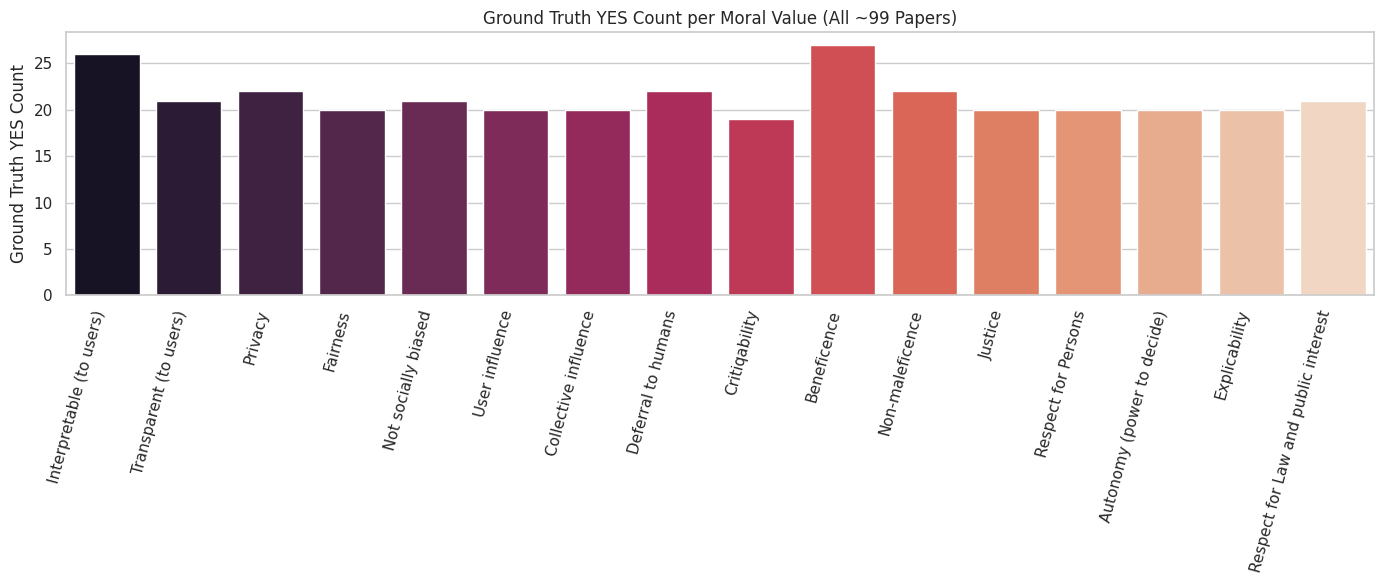

In [10]:
true_yes_counts = labels_f.sum(axis=0)  # labels_f shape: [N,16]

plt.figure(figsize=(14,6))
sns.barplot(x=MORAL_VALUES, y=true_yes_counts, palette="rocket")
plt.xticks(rotation=75, ha="right")
plt.ylabel("Ground Truth YES Count")
plt.title("Ground Truth YES Count per Moral Value (All ~99 Papers)")
plt.tight_layout()
plt.show()


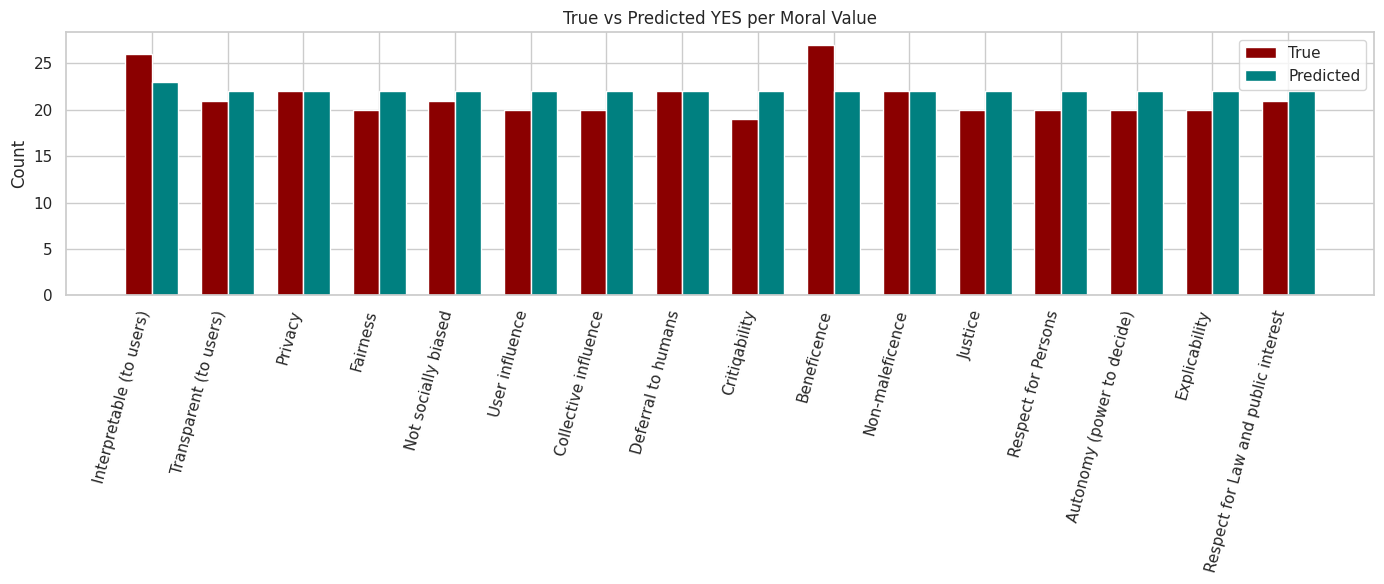

In [11]:
import numpy as np

x = np.arange(len(MORAL_VALUES))
width = 0.35

plt.figure(figsize=(14,6))
plt.bar(x - width/2, true_yes_counts, width, label="True", color="darkred")
plt.bar(x + width/2, pred_yes_counts, width, label="Predicted", color="teal")

plt.xticks(x, MORAL_VALUES, rotation=75, ha="right")
plt.ylabel("Count")
plt.title("True vs Predicted YES per Moral Value")
plt.legend()
plt.tight_layout()
plt.show()


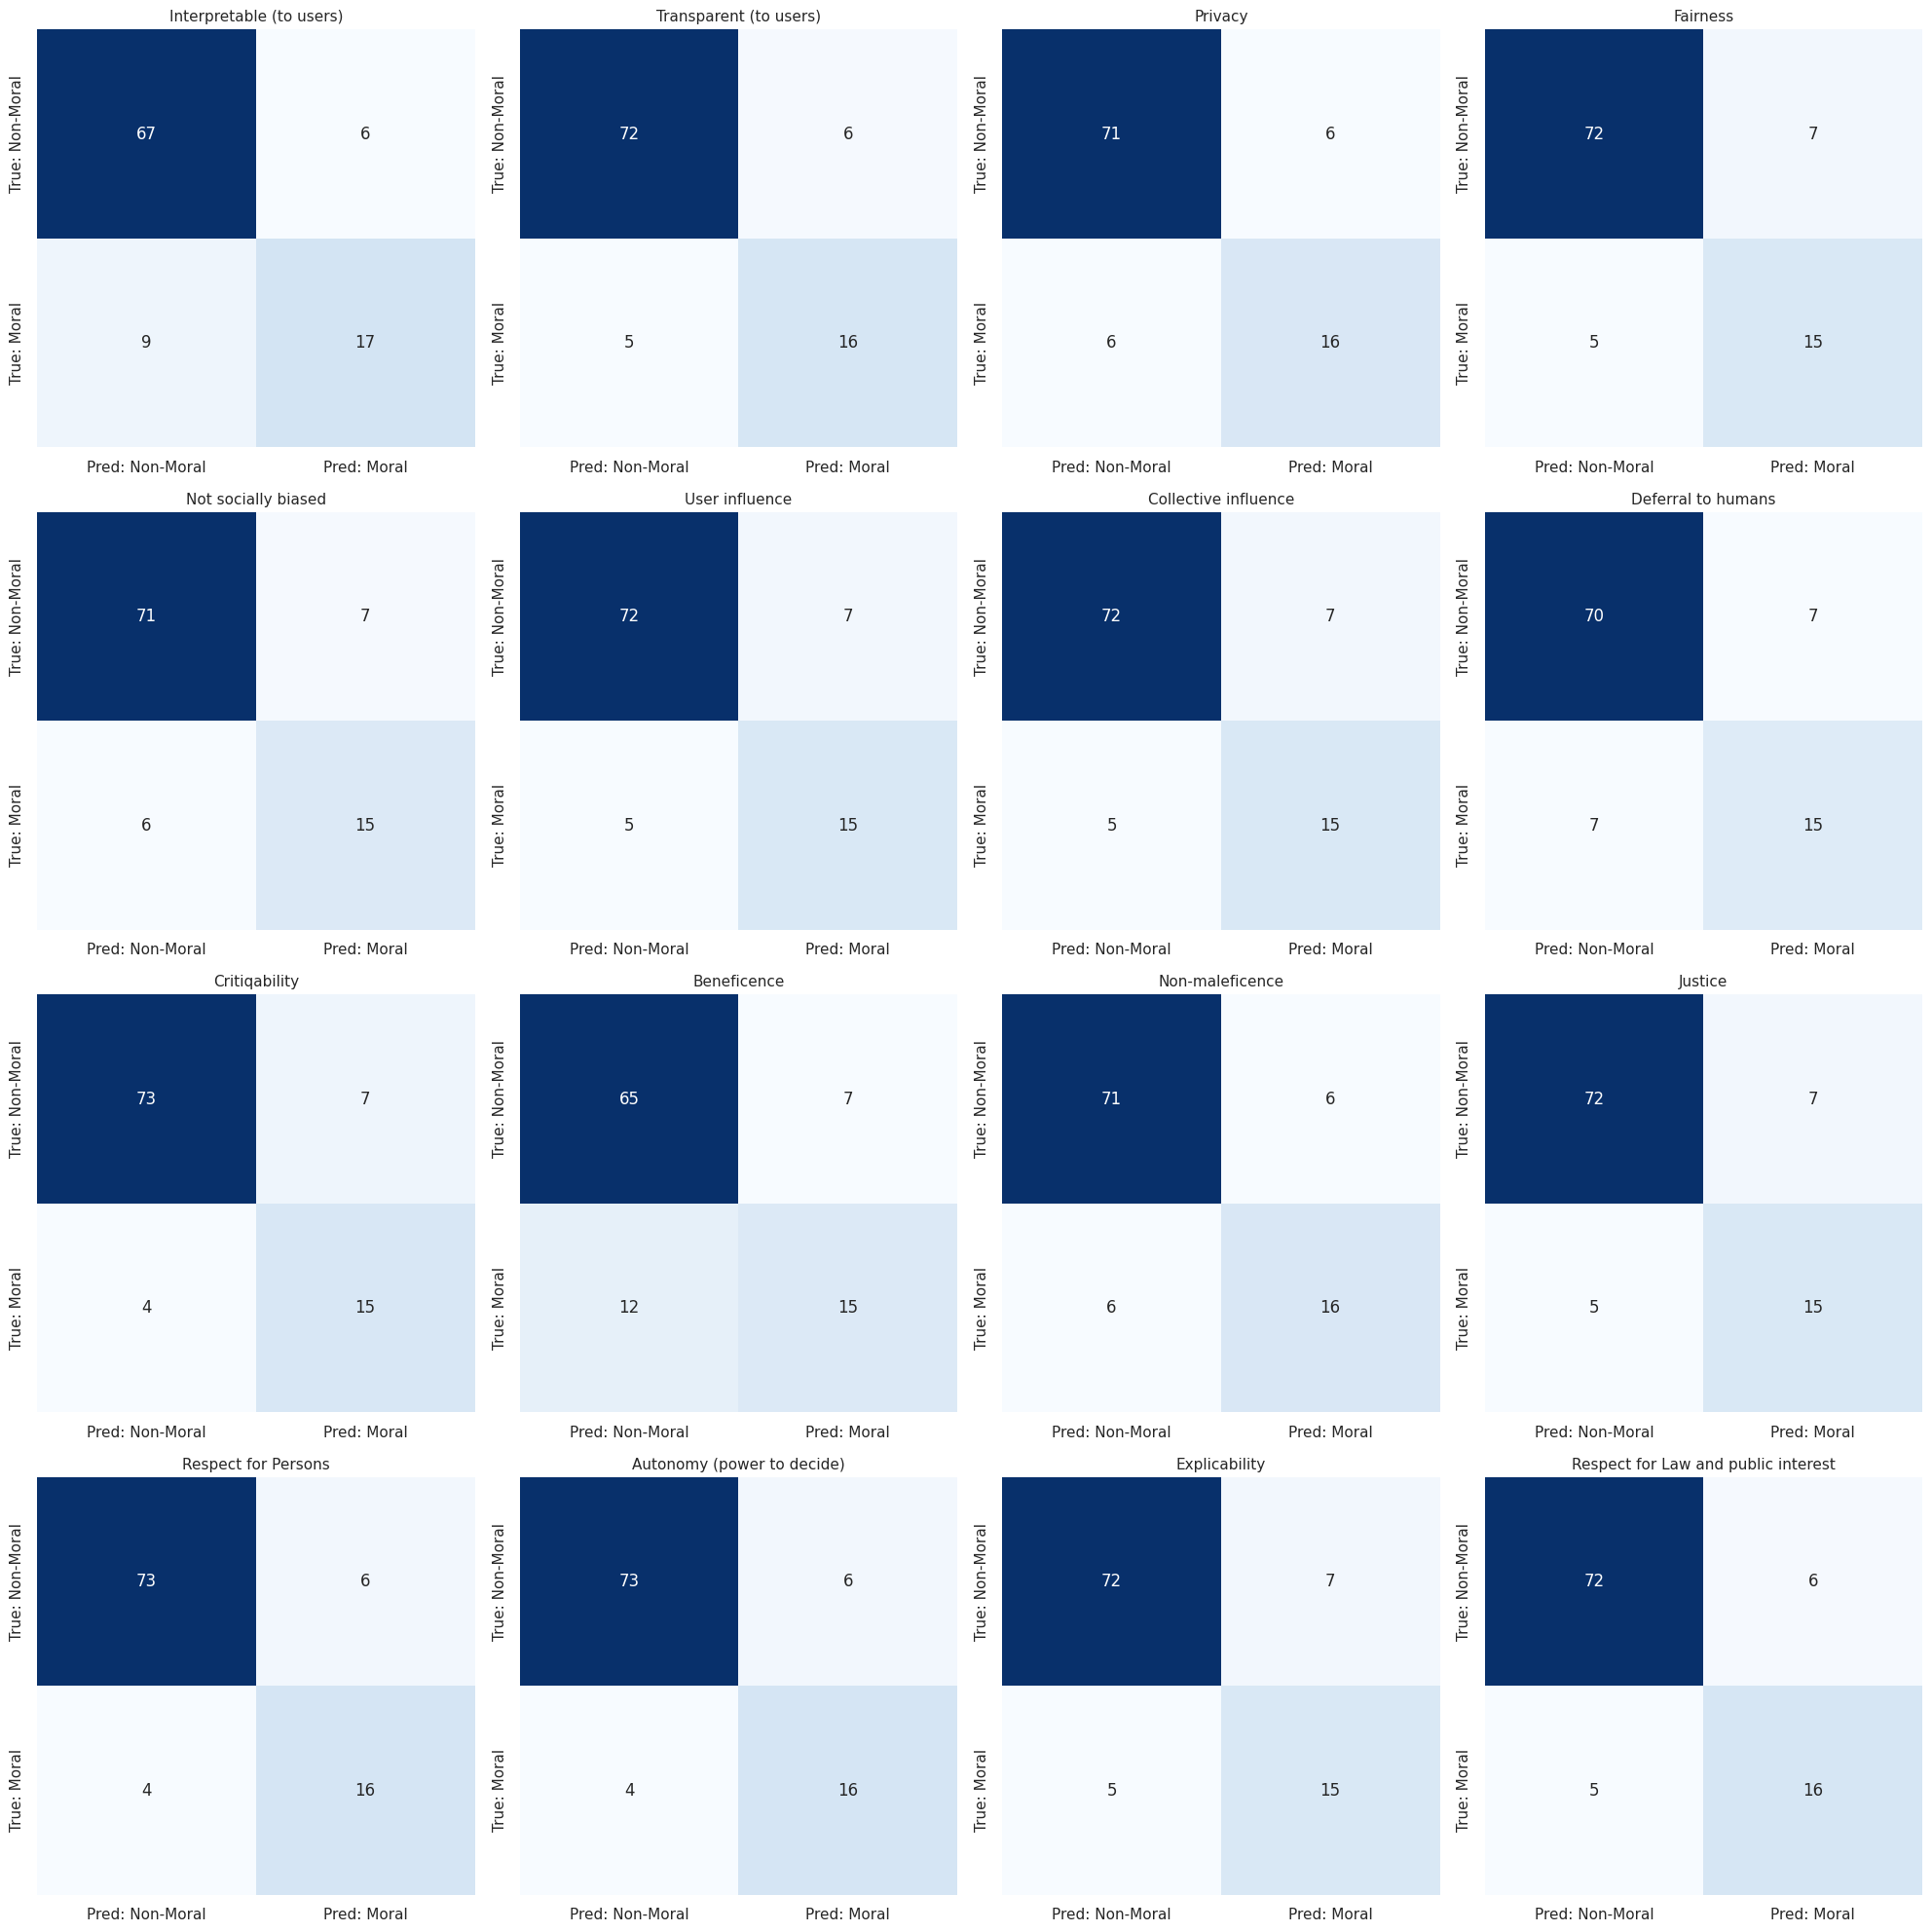

Saved all confusion matrices to: /content/drive/MyDrive/confusion_matrices_16_values


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

sns.set(style="white")

# Pretty labels instead of 0/1
X_LABELS = ["Pred: Non-Moral", "Pred: Moral"]
Y_LABELS = ["True: Non-Moral", "True: Moral"]

num_labels = len(MORAL_VALUES)

# ---------- SHOW ALL 16 CONFUSION MATRICES (GRID) ----------
plt.figure(figsize=(20, 20))

for i, label_name in enumerate(MORAL_VALUES):
    y_true = labels_f[:, i]
    y_pred = preds_f[:, i]

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])

    plt.subplot(4, 4, i + 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=X_LABELS,
                yticklabels=Y_LABELS)
    plt.title(label_name, fontsize=11)
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()


# ---------- SAVE EACH CONFUSION MATRIX SEPARATELY ----------
SAVE_CM_DIR = "/content/drive/MyDrive/confusion_matrices_16_values"
os.makedirs(SAVE_CM_DIR, exist_ok=True)

for i, label_name in enumerate(MORAL_VALUES):
    y_true = labels_f[:, i]
    y_pred = preds_f[:, i]

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=X_LABELS,
                yticklabels=Y_LABELS)

    plt.title(label_name, fontsize=13)
    plt.tight_layout()

    # Save safely (clean filename)
    clean_name = label_name.replace(" ", "_").replace("(", "").replace(")", "")
    plt.savefig(f"{SAVE_CM_DIR}/{clean_name}.png")
    plt.close()

print(f"Saved all confusion matrices to: {SAVE_CM_DIR}")


In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from pathlib import Path

MODEL_DIR = Path("/content/drive/MyDrive/TESTING_OUTPUT/model20e.pth")  # SAME DIR

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_DIR,
    problem_type="multi_label_classification"
)
model.to(device)
model.eval()

print("✅ Model loaded from:", MODEL_DIR)


OSError: Incorrect path_or_model_id: '/content/drive/MyDrive/TESTING_OUTPUT/model20e.pth'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [ ]:
import json
from pathlib import Path

TEST_JSON_DIR = Path("/content/drive/MyDrive/Jason_Testing_All_Papers")  # <-- change
test_examples = []

for fp in sorted(TEST_JSON_DIR.glob("*.json")):
    d = json.loads(open(fp, encoding="utf-8").read())
    txt = (d.get("text") or "").strip()
    if txt:
        test_examples.append({"file": fp.name, "text": txt})

print("Loaded test JSON files:", len(test_examples))


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

MORAL_VALUES = [
    "Interpretable (to users)", "Transparent (to users)", "Privacy", "Fairness",
    "Not socially biased", "User influence", "Collective influence",
    "Deferral to humans", "Critiqability", "Beneficence", "Non-maleficence",
    "Justice", "Respect for Persons", "Autonomy (power to decide)",
    "Explicability", "Respect for Law and public interest"
]

results = []

for item in tqdm(test_examples):
    enc = tokenizer(
        item["text"],
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    preds = (probs >= 0.5).astype(int)
    moral_binary = 1 if preds.sum() > 0 else 0

    row = {
        "file": item["file"],
        "moral_or_not": "Moral" if moral_binary else "Non-Moral",
    }

    for i, v in enumerate(MORAL_VALUES):
        row[f"{v}_pred"] = int(preds[i])
        row[f"{v}_prob"] = float(probs[i])

    results.append(row)

df_test = pd.DataFrame(results)
df_test.head()


In [ ]:
OUTPUT_CSV = MODEL_DIR / "test_predictions.csv"
df_test.to_csv(OUTPUT_CSV, index=False)

print("✅ Saved:", OUTPUT_CSV)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

CSV_PATH = "/content/drive/MyDrive/TESTING_OUTPUT/test_predictions.csv"
df = pd.read_csv(CSV_PATH)

# ------------------------
# 1) Moral vs Non-Moral Count
# ------------------------
df["binary_pred"] = (df.filter(like="_pred").sum(axis=1) > 0).astype(int)

print("Moral:", df["binary_pred"].sum())
print("Non-Moral:", (df["binary_pred"]==0).sum())

plt.figure(figsize=(5,5))
sns.countplot(x=df["binary_pred"].map({0:"Non-Moral",1:"Moral"}), palette="Set2")
plt.title("Moral vs Non-Moral Predictions")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# ------------------------
# 2) Bar chart of YES counts for each value
# ------------------------
value_cols = [c for c in df.columns if c.endswith("_pred")]
values = [c.replace("_pred","") for c in value_cols]
yes_counts = df[value_cols].sum().values

plt.figure(figsize=(12,7))
sns.barplot(x=yes_counts, y=values, orient="h", palette="Blues_r")
plt.title("YES Prediction Count per Moral Value")
plt.xlabel("Count of YES")
plt.tight_layout()
plt.show()

# ------------------------
# 3) Histogram of probability confidence (all values)
# ------------------------
prob_cols = [c for c in df.columns if c.endswith("_prob")]
all_scores = df[prob_cols].values.flatten()

plt.figure(figsize=(9,5))
plt.hist(all_scores, bins=20, color="purple", alpha=0.7)
plt.title("Histogram of Prediction Confidence Scores (All 16 Values)")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

# ------------------------
# 4) Per-value histograms
# ------------------------
plt.figure(figsize=(16,12))
for i, v in enumerate(values):
    plt.subplot(4,4,i+1)
    plt.hist(df[f"{v}_prob"], bins=15, color="teal", alpha=0.7)
    plt.title(v)
    plt.tight_layout()
plt.suptitle("Per-Value Confidence Distributions", y=1.02, fontsize=16)
plt.show()

print("\n✅ Evaluation complete — no true labels needed.\n")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set(style="whitegrid")

# =======================================
# LOAD PREDICTIONS
# =======================================
CSV_PATH = "/content/drive/MyDrive/TESTING_OUTPUT/test_predictions.csv"
df = pd.read_csv(CSV_PATH)

# =======================================
# FIX: USE EXACT 16 MORAL VALUES
# =======================================
MORAL_VALUES = [
    "Interpretable (to users)", "Transparent (to users)", "Privacy", "Fairness",
    "Not socially biased", "User influence", "Collective influence",
    "Deferral to humans", "Critiqability", "Beneficence", "Non-maleficence",
    "Justice", "Respect for Persons", "Autonomy (power to decide)",
    "Explicability", "Respect for Law and public interest"
]

# Build the *_pred and *_prob column names
pred_cols = [v + "_pred" for v in MORAL_VALUES]
prob_cols = [v + "_prob" for v in MORAL_VALUES]

# =======================================
# 1) Moral vs Non-Moral Count
# =======================================
df["binary_pred"] = (df[pred_cols].sum(axis=1) > 0).astype(int)

print("Moral:", df["binary_pred"].sum())
print("Non-Moral:", (df["binary_pred"]==0).sum())

plt.figure(figsize=(5,5))
sns.countplot(x=df["binary_pred"].map({0:"Non-Moral",1:"Moral"}), palette="Set2")
plt.title("Moral vs Non-Moral Predictions")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# =======================================
# 2) Bar chart of YES counts for each value
# =======================================
yes_counts = df[pred_cols].sum().values

plt.figure(figsize=(12,7))
sns.barplot(x=yes_counts, y=MORAL_VALUES, orient="h", palette="Blues_r")
plt.title("YES Prediction Count per Moral Value")
plt.xlabel("Count of YES")
plt.tight_layout()
plt.show()

# =======================================
# 3) Histogram of ALL prediction confidence scores
# =======================================
all_scores = df[prob_cols].values.flatten()

plt.figure(figsize=(9,5))
plt.hist(all_scores, bins=20, color="purple", alpha=0.7)
plt.title("Histogram of Prediction Confidence Scores (All 16 Values)")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

# =======================================
# 4) Per-value histograms (16 moral values)
# =======================================
plt.figure(figsize=(16,12))
for i, v in enumerate(MORAL_VALUES):
    plt.subplot(4,4,i+1)
    plt.hist(df[f"{v}_prob"], bins=15, color="teal", alpha=0.7)
    plt.title(v)
    plt.tight_layout()
plt.suptitle("Per-Value Confidence Distributions", y=1.02, fontsize=16)
plt.show()

# =======================================
# 5) CONFUSION MATRIX FOR EACH VALUE (PREDICTION ONLY)
#    (True labels unavailable → we use predicted 0/1 vs "not predicted")
# =======================================
import os
SAVE_CM_DIR ="/content/drive/MyDrive/TESTING_OUTPUT/confusion_matrices_16_valuesallpapers"
os.makedirs(SAVE_CM_DIR, exist_ok=True)

plt.figure(figsize=(16,12))
for i, v in enumerate(MORAL_VALUES):
    y_pred = df[f"{v}_pred"].values

    # Fake "true" labels for visualization (predict vs not predicted)
    y_true = np.zeros_like(y_pred)   # treat predictions as events

    # Build confusion matrix based on predicted 0/1 only
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])

    plt.subplot(4,4,i+1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=["Pred 0","Pred 1"],
                yticklabels=["True 0","True 1"])
    plt.title(v)
    plt.tight_layout()

    # save each confusion matrix
    plt.savefig(f"{SAVE_CM_DIR}/{v.replace(' ','_')}.png")

plt.suptitle("Confusion Matrices (Prediction-Only)", y=1.02, fontsize=16)
plt.show()

print("\n✅ Evaluation complete — including confusion matrices (prediction-only).\n")
